# Pytorch tutorial

In [2]:
%matplotlib inline  
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn

## Tensors
Tensors are similar to NumPy’s ndarrays, with the addition being that
Tensors can also be used on a GPU to accelerate computing. 

In [3]:
# Construct a 5x3 matrix, uninitialized:

x = torch.empty(5, 3)
print(x)

tensor([[-4.0399e+06,  4.5786e-41, -3.7128e+06],
        [ 4.5786e-41, -3.9763e+06,  4.5786e-41],
        [-4.1086e+06,  4.5786e-41, -4.1058e+06],
        [ 4.5786e-41, -4.0399e+06,  4.5786e-41],
        [-3.8557e+06,  4.5786e-41, -4.0403e+06]])


In [4]:
# Construct a randomly initialized matrix:

x = torch.rand(5, 3)
print(x)

tensor([[0.2789, 0.3831, 0.7094],
        [0.3637, 0.2191, 0.3216],
        [0.9340, 0.8689, 0.7928],
        [0.7678, 0.3283, 0.4715],
        [0.5506, 0.8742, 0.2042]])


In [5]:
# Matrix multiplication
y = torch.rand(3,5)
prod = torch.matmul(x,y)
print(prod)

tensor([[0.8990, 0.6690, 0.9145, 0.8442, 0.3050],
        [0.5486, 0.4085, 0.6263, 0.4287, 0.3074],
        [1.5565, 1.2435, 1.6409, 1.2895, 0.8029],
        [0.9221, 0.6769, 1.1200, 0.6473, 0.6158],
        [0.9197, 0.8622, 0.8162, 0.8067, 0.4617]])


In [6]:
# Construct a tensor directly from data:

x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


In [7]:
# check a tensor shape

x.shape

torch.Size([2])

## Autograd: Automatic Differentiation


Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



Create a tensor and set ``requires_grad=True`` to track computation with it

In [8]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation

In [9]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.


In [10]:
print(y.grad_fn)


Do more operations on ``y``

In [11]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


## Gradients

Let's backprop now.
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1.))``.

In [12]:
out.backward()

Print gradients $\partial_x out$

In [13]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.

## Data

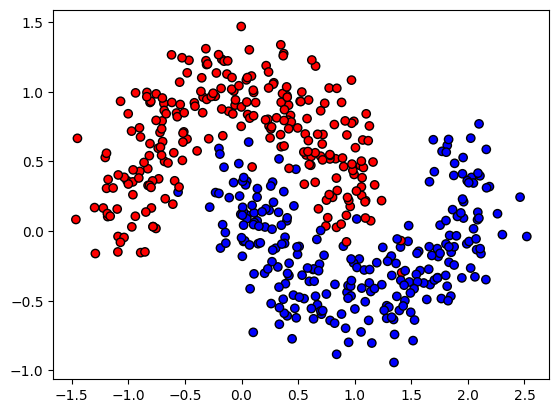

In [14]:
X, y = make_moons(n_samples = 500, noise = 0.2, random_state = 101)

# visualisation
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)

## Neural Networks


Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

### Define the network


Let’s define this network:



In [15]:
class ANN(nn.Module):
    
    def __init__(self, n_hidden):
        super(ANN, self).__init__()
        self.i_h = nn.Sequential(nn.Linear(2, n_hidden), nn.Sigmoid())
        self.h_o = nn.Sequential(nn.Linear(n_hidden, 1), nn.Sigmoid())
        
    def forward(self, x):
        h = self.i_h(x)
        output = self.h_o(h)
        return output
    
n_hidden = 30
net = ANN(n_hidden = n_hidden)
print(net)

ANN(
  (i_h): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (h_o): Sequential(
    (0): Linear(in_features=30, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()`` or by ``net.state_dict()``



In [16]:
print(net.state_dict())

OrderedDict([('i_h.0.weight', tensor([[-0.4498, -0.6562],
        [ 0.6882,  0.1299],
        [ 0.2559, -0.5503],
        [-0.6593, -0.5267],
        [ 0.1712, -0.6013],
        [-0.4896,  0.0577],
        [ 0.6469,  0.6399],
        [ 0.2335,  0.0549],
        [ 0.4768,  0.6165],
        [ 0.5739,  0.4902],
        [ 0.3317,  0.2007],
        [ 0.0156,  0.3051],
        [ 0.6882, -0.4652],
        [ 0.4010, -0.2838],
        [ 0.1541, -0.1273],
        [ 0.3788,  0.3047],
        [ 0.3541,  0.1470],
        [-0.1271,  0.0028],
        [-0.3559, -0.7071],
        [ 0.4399, -0.3782],
        [-0.2555, -0.6346],
        [ 0.6286,  0.1694],
        [ 0.1993, -0.5393],
        [ 0.2533, -0.4978],
        [-0.2011,  0.2295],
        [-0.5489, -0.5030],
        [-0.0867, -0.6541],
        [ 0.5374,  0.2652],
        [-0.1885,  0.3952],
        [-0.3078, -0.5134]])), ('i_h.0.bias', tensor([-0.3349, -0.2208,  0.5271, -0.0609, -0.1369,  0.1959,  0.6738, -0.0471,
         0.2348,  0.3557,  0.271

Before proceeding further, let's recap all the classes we’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <https://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.BCELoss`` which computes the log-likelihood of the data assuming it's sampled from a Bernouilli distribution.

For example:

In [17]:
# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
target = torch.tensor(y, dtype=torch.float32).view(-1,1)

y_output = net(X_tensor)
loss_fn = nn.BCELoss(reduction="sum")
loss = loss_fn(y_output, target)
print(loss)



tensor(342.1576, grad_fn=<BinaryCrossEntropyBackward0>)


Let's start follwing ``loss`` in the backward direction in its graph to see which functions created it.

In [18]:
print(loss.grad_fn)  # BCELoss
print(loss.grad_fn.next_functions[0][0])  # Sigmoid
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # Linear

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at the network's parameters




In [19]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('grad of parameters of network before backward')
for param in net.parameters():
    print(param.grad)

loss.backward()
print('grad of parameters of network after backward')
for param in net.parameters():
    print(param.grad)




grad of parameters of network before backward
None
None
None
None
grad of parameters of network after backward
tensor([[ 1.9829, -1.9243],
        [ 2.5956, -3.1937],
        [-2.4178,  2.8430],
        [-3.7160,  4.1875],
        [ 0.7449, -0.7077],
        [ 3.0909, -3.4510],
        [-2.5060,  2.5215],
        [-2.1845,  2.2572],
        [ 1.2076, -1.2115],
        [-2.3561,  2.5252],
        [ 2.5277, -2.6705],
        [ 3.5710, -3.4407],
        [-2.7402,  3.1136],
        [ 3.5905, -3.8934],
        [ 1.1995, -1.2835],
        [-3.4497,  3.5738],
        [-2.6646,  2.7175],
        [-4.4194,  4.3934],
        [-3.2205,  2.9331],
        [ 0.3829, -0.4474],
        [-0.4983,  0.4878],
        [-1.7084,  2.0725],
        [-2.8106,  3.3371],
        [-0.4484,  0.4073],
        [ 2.6235, -2.9124],
        [ 0.1379, -0.1523],
        [-1.0004,  0.8431],
        [-0.4567,  0.5176],
        [-0.0081,  0.0083],
        [-3.8602,  3.6227]])
tensor([-0.6720, -1.2803,  1.5348,  1.7156, -0.2

### Update the weights
Recall that the optimisation of the loss function using Stochastic Gradient Descent is performed as follows:
- Initialise $W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}$.
- While Not convergence:
    - Calculate $J(\theta)$
    - Update $W^{[i]} := W^{[i]} - \alpha \cdot \partial_{W^{[i]}}J$
    - Update $b^{[i]} := b^{[i]} - \alpha \cdot \partial_{b^{[i]}}J$
    
However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
Pytorch has the package ``torch.optim`` that
implements all these methods. Using it is very simple:



In [20]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.)
print('Value of parameters of network before optimizer step:')
for param in net.parameters():
    print(param)



Value of parameters of network before optimizer step:
Parameter containing:
tensor([[-0.4498, -0.6562],
        [ 0.6882,  0.1299],
        [ 0.2559, -0.5503],
        [-0.6593, -0.5267],
        [ 0.1712, -0.6013],
        [-0.4896,  0.0577],
        [ 0.6469,  0.6399],
        [ 0.2335,  0.0549],
        [ 0.4768,  0.6165],
        [ 0.5739,  0.4902],
        [ 0.3317,  0.2007],
        [ 0.0156,  0.3051],
        [ 0.6882, -0.4652],
        [ 0.4010, -0.2838],
        [ 0.1541, -0.1273],
        [ 0.3788,  0.3047],
        [ 0.3541,  0.1470],
        [-0.1271,  0.0028],
        [-0.3559, -0.7071],
        [ 0.4399, -0.3782],
        [-0.2555, -0.6346],
        [ 0.6286,  0.1694],
        [ 0.1993, -0.5393],
        [ 0.2533, -0.4978],
        [-0.2011,  0.2295],
        [-0.5489, -0.5030],
        [-0.0867, -0.6541],
        [ 0.5374,  0.2652],
        [-0.1885,  0.3952],
        [-0.3078, -0.5134]], requires_grad=True)
Parameter containing:
tensor([-0.3349, -0.2208,  0.5271, -0.060

In [21]:
print('Value of parameters of network after optimizer step: ')
for param in net.parameters():
    print(param)

optimizer.step()

Value of parameters of network after optimizer step: 
Parameter containing:
tensor([[-0.4498, -0.6562],
        [ 0.6882,  0.1299],
        [ 0.2559, -0.5503],
        [-0.6593, -0.5267],
        [ 0.1712, -0.6013],
        [-0.4896,  0.0577],
        [ 0.6469,  0.6399],
        [ 0.2335,  0.0549],
        [ 0.4768,  0.6165],
        [ 0.5739,  0.4902],
        [ 0.3317,  0.2007],
        [ 0.0156,  0.3051],
        [ 0.6882, -0.4652],
        [ 0.4010, -0.2838],
        [ 0.1541, -0.1273],
        [ 0.3788,  0.3047],
        [ 0.3541,  0.1470],
        [-0.1271,  0.0028],
        [-0.3559, -0.7071],
        [ 0.4399, -0.3782],
        [-0.2555, -0.6346],
        [ 0.6286,  0.1694],
        [ 0.1993, -0.5393],
        [ 0.2533, -0.4978],
        [-0.2011,  0.2295],
        [-0.5489, -0.5030],
        [-0.0867, -0.6541],
        [ 0.5374,  0.2652],
        [-0.1885,  0.3952],
        [-0.3078, -0.5134]], requires_grad=True)
Parameter containing:
tensor([-0.3349, -0.2208,  0.5271, -0.060

### Let's put everything together

In [26]:
%%time
n_hidden = 30
net = ANN(n_hidden = n_hidden)

# optimizer
lr = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

# loss function
loss_fn = torch.nn.BCELoss(reduction="sum")

# data to tensor
X_tensor = torch.tensor(X, dtype = torch.float)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

# training
n_epochs = 10000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = net(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        print("Iteration {}/{}, loss {:.4f}".format(epoch, n_epochs, loss.item()))

Iteration 0/10000, loss 364.0011
Iteration 100/10000, loss 149.8850
Iteration 200/10000, loss 138.7191
Iteration 300/10000, loss 137.1034
Iteration 400/10000, loss 136.8003
Iteration 500/10000, loss 136.6995
Iteration 600/10000, loss 136.6324
Iteration 700/10000, loss 136.5707
Iteration 800/10000, loss 136.5089
Iteration 900/10000, loss 136.4449
Iteration 1000/10000, loss 136.3768
Iteration 1100/10000, loss 136.3027
Iteration 1200/10000, loss 136.2196
Iteration 1300/10000, loss 136.1234
Iteration 1400/10000, loss 136.0079
Iteration 1500/10000, loss 135.8638
Iteration 1600/10000, loss 135.6763
Iteration 1700/10000, loss 135.4217
Iteration 1800/10000, loss 135.0609
Iteration 1900/10000, loss 134.5284
Iteration 2000/10000, loss 133.7124
Iteration 2100/10000, loss 132.4221
Iteration 2200/10000, loss 130.3422
Iteration 2300/10000, loss 127.0086
Iteration 2400/10000, loss 121.9154
Iteration 2500/10000, loss 114.8604
Iteration 2600/10000, loss 106.3013
Iteration 2700/10000, loss 97.2267
Itera

... and we plot the result

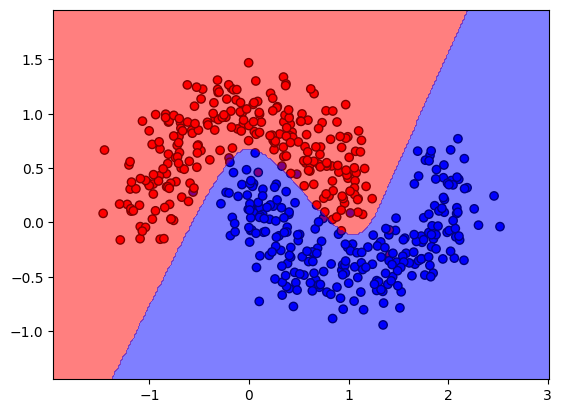

In [25]:
# plotting
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xx_tensor, yy_tensor = torch.tensor(xx, dtype=torch.float), torch.tensor(yy, dtype=torch.float)
Z = net(torch.stack([xx_tensor.flatten(), yy_tensor.flatten()], 1))
Z = Z.detach().numpy()
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)